# 고혈압 분석 모델
## @author: sh22h

- year0_NA를 DataFrame으로 불러오고 4개로 나눔
  - binary: 범주형(binary) 변수, 0 / 1 로 변경
  - categoryH0: 계층 없는 범주형(>3) 변수, one-hot-encoding
  - categoryH1: 계층 있는 범주형 변수, 표준화
  - ctn:연속형 변수, 정규화, 표준화 
  - hyperTension: 고혈압

- 각각 정규화 또는 표준화한 후 변수는 X 고혈압은 y로 둠
  - 정규화(normalization): 0, 1
  - 표준화(standardization): 평균: 0 표준편차: 1
  - 계층화(quantile transform): 4분위 수

## 학습 모델

- 0차
  - 로컬에서 구현

- 1차
  - 2021-07-20
  - normalize_ctn
  - 
  ```
  model = Sequential()
  model.add(Dense(12, input_dim=52, activation='relu'))  # input layer requires input_dim param
  model.add(Dense(15, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))  # sigmoid instead of relu for final probability between 0 and 1
  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
  history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
  scores = model.evaluate(X_test, y_test)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))
  ```

- 2차
  - 2021-07-26
  - Decision Tree 구현

- 3차
  - 2021-08-02
  - one-hot encoding 구현

- 4차
  - 2021-08-07
  - 전처리 개선
  - Keras Tunor 사용 준비
  - P1 ~ P4 모델 구현

- 5차
  - 2021-08-08
  - 데이터 결측값 관리
    - TOTALC 유의미한 값: 15개
    - 키, 몸무게 결측값 매우 많음
  - 데이터 결측값 제거
    - TOTALC 삭제
    - KNNImputer로 결측값 채우기
    - https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer

- 6차
  - 2021-08-12
  - 데이터 결측값 관리
    - 변수 모두 포함하라!
    - 범주형: 최빈값
    - 수치형: 평균값(kNN)
    - TOTALC 포함하라
    - 주말까지
  - DicisionTree 보는 법을 해석하라.
  - 모델 정확도 올리기

- 7차
  - 2021-08-23
  - unit 통일
  - dropout 통일
  - 모델 정확도 여전히 안좋음

- 8차
  - 2021-08-24
  - unit, dropout 다시 분리
  - 레이어 늘림

- 9차
  - 2021-08-26
  - 변수 중요도 낮은 변수 일부 제거하고 모델 돌려보기
    - 영향을 조금이라도 주는 것
      1. 'AS1_AGE'
      2. 'AS1_WEIGHT'
      3. 'AS1_B18'
      4. 'AS1_SEX'
      5. 'P3'
      6. 'AS1_B01'
      7. 'AS1_B04'
    - 나머지, 영향 없음.

- 10차
  - 2021-08-29
  - unit 통일
  - dropout 통일
 
- 11차
  - 2021-08-30
  - max_epoch = 10으로 통일

- 12차
  - 데이터셋 변경

- 13차
  - 2021-09-09
  - 데이터셋 변경
    - P1 ~ P4 -> FA1 ~ FA5 
    - column 54

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 데이터 불러오기

In [2]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/year0_FA_210909.csv', index_col=0, na_values=['NA'])

idx_dataset = list(dataset.index)
col_dataset = list(dataset.columns)
# dataset.info()

### dataset 결측값 대치, 정규화

In [3]:
# dataset에 있는 변수 분리
# 범주형, 연속형 등으로 분리하여 raw_var 형태로 저장하여 각각 관리한다.

# 종속변수, 고혈압
HYPERTENSION = dataset['HYPERTENSION']

# 범주형(binary, 0 or 1)
raw_binary = dataset.reindex(columns=['AS1_SEX', 'AS0_TIED', 'AS0_SLPAMSF', 'AS1_STRPHYSJ'])
col_b = raw_binary.columns

#범주형(계층 없음, without hierarchy)
raw_categoryH0 = dataset.reindex(columns=['AS1_JOBB', 'AS1_INSUR'])
col_H0 = raw_categoryH0.columns

# 범주형(계층 있음, with hierarchy)
raw_categoryH1 = dataset.reindex(columns=['AS1_EDUA', 'AS1_INCOME', 'AS1_DRINK', 'AS1_DRDUA',
                                          'AS1_SMOKEA', 'AS1_PHYSTB', 'AS1_PHYSIT', 'AS1_PHYACTL',
                                          'AS1_PHYACTM', 'AS1_PHYACTH', 'AS1_HEALTH'
                                          ])
col_H1 = raw_categoryH1.columns

# 연속형 변수
raw_ctn = dataset.reindex(columns=['AS1_AGE', 'AS1_HVSMAM', 'AS1_HVSMDU', 'AS1_TOTALC',
                                   'AS1_SLPAMTM', 'AS1_RGMEALFQA', 'AS1_HEIGHT', 'AS1_WEIGHT',
                                   'AS1_B01', 'AS1_B02', 'AS1_B03', 'AS1_B04', 'AS1_B05',
                                   'AS1_B06', 'AS1_B07', 'AS1_B08', 'AS1_B09', 'AS1_B10',
                                   'AS1_B11', 'AS1_B12', 'AS1_B13', 'AS1_B14', 'AS1_B15',
                                   'AS1_B16', 'AS1_B17', 'AS1_B18', 'AS1_B19', 'AS1_B20',
                                   'AS1_B21', 'AS1_B23', 'AS1_B24',
                                   'FA1', 'FA2', 'FA3', 'FA4', 'FA5' # 패턴 변경
                                   ])
col_c = raw_ctn.columns

In [4]:
# print(raw_binary.info(), raw_categoryH0.info(), raw_categoryH1.info(), raw_ctn.info())
# print(col_b, col_H0, col_H1, col_c)

In [5]:
from sklearn.impute import KNNImputer, SimpleImputer

imp_kNN = KNNImputer(n_neighbors=5)
imp_mean = SimpleImputer(strategy='mean')
imp_mostFreq = SimpleImputer(strategy='most_frequent')

In [6]:
# 최빈값으로 대치
binary = pd.DataFrame(imp_mostFreq.fit_transform(raw_binary),
                      index=idx_dataset, columns=col_b).astype('float') # float형으로 변경.

categoryH0 = pd.DataFrame(imp_mostFreq.fit_transform(raw_categoryH0), 
                          index=idx_dataset, columns=col_H0)
categoryH0 = pd.get_dummies(categoryH0, columns=col_H0).astype('float') # one-hot-encoding

categoryH1 = pd.DataFrame(imp_mostFreq.fit_transform(raw_categoryH1),
                          index=idx_dataset, columns=col_H1)

# kNN, 평균 둘 중 하나만 사용할 예정
ctn = pd.DataFrame(imp_kNN.fit_transform(raw_ctn), index=idx_dataset, columns=col_c)
# ctn = pd.DataFrame(imp_mean.fit_transform(raw_ctn), index=idx_dataset, columns=col_c)


In [7]:
# print(binary.info(), categoryH0.info(), categoryH1.info(), ctn.info())

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.model_selection import train_test_split

scaler0 = StandardScaler()
scaler1 = MinMaxScaler()
scaler2 = QuantileTransformer()

# category_h1, ctn 정규화
# train만으로 scale 해야하는가? 교수님에게 질문해보기

def standard(categoryH1, ctn):
  categoryH1[col_H1] = scaler0.fit_transform(categoryH1)
  ctn[col_c] = scaler0.fit_transform(ctn)

  return categoryH1, ctn


def minmax(categoryH1, ctn):
  categoryH1[col_H1] = scaler1.fit_transform(categoryH1)
  ctn[col_c] = scaler1.fit_transform(ctn)

  return categoryH1, ctn


def quantile(categoryH1, ctn):
  categoryH1[col_H1] = scaler2.fit_transform(categoryH1)
  ctn[col_c] = scaler2.fit_transform(ctn)

  return categoryH1, ctn

In [9]:
# categoryH1, ctn = standard(categoryH1, ctn)
# categoryH1, ctn = minmax(categoryH1, ctn)
categoryH1, ctn = quantile(categoryH1, ctn)

### dataset 분리
- train, test

In [10]:
X = pd.concat([binary, categoryH0, categoryH1, ctn], axis=1)
y = dataset['HYPERTENSION']  # 고혈압 변수

# 훈련 데이터 나눔
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [11]:
# X_train.head()

### 모델 제작

In [ ]:
import IPython
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

!pip install -q -U keras-tuner
import keras_tuner as kt
from keras_tuner import HyperModel

     |████████████████████████████████| 97 kB 3.1 MB/s 


In [ ]:
EPOCH = 128

In [ ]:
class RegressionHyperModel(HyperModel):
  def __init__(self, input_shape):
    self.input_shape = input_shape

def model_builder(hp):
  model = Sequential()
  hp_units = hp.Int('units', min_value = 4, max_value = 64, step = 2)
  hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.05, step=0.05)

  model.add(Dense(units = hp_units, activation='relu')) # input_shape = 63
  
  model.add(Dropout(hp_dropout))
  model.add(Dense(units = hp_units, activation='relu'))
  
  # model.add(Dropout(hp_dropout))
  # model.add(Dense(units = hp_units, activation='relu'))
  
  # model.add(Dropout(hp_dropout))
  # model.add(Dense(units = hp_units, activation='relu'))
  
  # model.add(Dropout(hp_dropout))
  # model.add(Dense(units = hp_units, activation='relu'))

  model.add(Dropout(hp_dropout))
  model.add(Dense(1, activation='sigmoid')) # 출력층 

  # Tune the learning rate for the optimizer S
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3]) # 0.01 or 0.001

  model.compile(optimizer = Adam(learning_rate = hp_learning_rate),
                loss="binary_crossentropy", # 손실함수: binary_crossentropy
                metrics = ['accuracy']) # 평가지표

  # model.compile(optimizer='rmsprop', 
  #               loss='mse', metrics=['mse']) #손실함수: MSE(mean squared error)
  
  return model

In [ ]:
class ClearTrainingOutput(keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
input_shape = (X_train.shape[1],)
hypermodel = RegressionHyperModel(input_shape)

tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = EPOCH,
                     hyperband_iterations = 100,
                     directory = '/content/drive/MyDrive/Colab Notebooks',
                     project_name = 'HyperTension_sh22h_fa02')

tuner.search(X_train, y_train,
             epochs = EPOCH,
             validation_split=0.2,
             callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
//하이퍼 파라미터 검색 완료//
최적의 은닉층 unit 수는
{best_hps.get('units')}
최적의 학습률은
{best_hps.get('learning_rate')}
최적의 드롭아웃 확률은
{best_hps.get('dropout')}.
""")

Trial 474 Complete [00h 00m 01s]
val_accuracy: 0.7572440505027771

Best val_accuracy So Far: 0.7643271088600159
Total elapsed time: 00h 36m 25s
INFO:tensorflow:Oracle triggered exit

//하이퍼 파라미터 검색 완료//
최적의 은닉층 unit 수는
8
최적의 학습률은
0.001
최적의 드롭아웃 확률은
0.0.



#### best_hps

- 2021-08-08
  ```
  INFO:tensorflow:Oracle triggered exit
  The hyperparameter search is complete. The optimal number of units in the densely-connected layer is
  72, 8, 104, 32)
   the optimal learning rate for the optimizer is
  0.001
  drop-out is
  (0.03, 0.06).
  ```
  - min_value = 8, max_value = 128, step = 8

- 2021-08-12
  ```
  Best val_accuracy So Far: 0.7678571343421936
  Total elapsed time: 00h 00m 33s
  INFO:tensorflow:Oracle triggered exit
  The hyperparameter search is complete. The optimal number of units in the densely-connected layer is
  (10, 16, 6, 24)
  and the optimal learning rate for the optimizer is
  0.0001
  drop-out is
  (0.044, 0.096).
  ```

  - min_value = 2, max_value = 32, step = 2

- 2021-08-14
  ```
  Best val_accuracy So Far: 0.7726648449897766
  Total elapsed time: 00h 01m 27s
  INFO:tensorflow:Oracle triggered exit

  The hyperparameter search is complete. The optimal number of units in the densely-connected layer is
  (16, 8, 14, 8)
  and the optimal learning rate for the optimizer is
  0.0001
  drop-out is
  (0.085, 0.09).
  ```

  - min_value = 4, max_value = 32, step = 2

- 2021-08-23
  ```
  Trial 16 Complete [00h 00m 21s]
  val_accuracy: 0.7726648449897766

  Best val_accuracy So Far: 0.7743818759918213
  Total elapsed time: 00h 01m 49s
  INFO:tensorflow:Oracle triggered exit

  The hyperparameter search is complete. The optimal number of units in the densely-connected layer is
  28
  and the optimal learning rate for the optimizer is
  0.01
  drop-out is
  0.05.
  ```
- 중요한 변수만 했을때
  - 0.7743818759918213
  - 큰 차이 없음

- 2021-08-29
  ```
  Trial 184 Complete [00h 00m 02s]
  val_accuracy: 0.7779740691184998

  Best val_accuracy So Far: 0.7891637086868286
  Total elapsed time: 00h 22m 51s
  INFO:tensorflow:Oracle triggered exit

  The hyperparameter search is complete.
  The optimal number of units in the densely-connected layer is
  30
  and the optimal learning rate for the optimizer is
  0.001
  drop-out is
  0.05.
  ```

- 2021-08-30
  ```
  Trial 382 Complete [00h 00m 07s]
  val_accuracy: 0.7623953819274902

  Best val_accuracy So Far: 0.7707662582397461
  Total elapsed time: 00h 27m 33s
  INFO:tensorflow:Oracle triggered exit

  The hyperparameter search is complete.
  The optimal number of units in the densely-connected layer is
  22
  and the optimal learning rate for the optimizer is
  0.001
  drop-out is
  0.0.
  ```

```
Trial 441 Complete [00h 00m 05s]
val_accuracy: 0.765614926815033

Best val_accuracy So Far: 0.7701223492622375
Total elapsed time: 00h 33m 03s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
The optimal number of units in the densely-connected layer is
30
and the optimal learning rate for the optimizer is
0.001
drop-out is
0.05.
```

```
Trial 90 Complete [00h 00m 21s]
val_accuracy: 0.7604635953903198

Best val_accuracy So Far: 0.7617514729499817
Total elapsed time: 00h 07m 40s
INFO:tensorflow:Oracle triggered exit

//하이퍼 파라미터 검색 완료//
최적의 은닉층 unit 수는
56
최적의 학습률은
0.01
최적의 드롭아웃 확률은
0.2
```

In [ ]:
best_hps.get_config()

{'space': [{'class_name': 'Int',
   'config': {'conditions': [],
    'default': None,
    'max_value': 64,
    'min_value': 4,
    'name': 'units',
    'sampling': None,
    'step': 2}},
  {'class_name': 'Float',
   'config': {'conditions': [],
    'default': 0.05,
    'max_value': 0.5,
    'min_value': 0.0,
    'name': 'dropout',
    'sampling': None,
    'step': 0.05}},
  {'class_name': 'Choice',
   'config': {'conditions': [],
    'default': 0.01,
    'name': 'learning_rate',
    'ordered': True,
    'values': [0.01, 0.001]}}],
 'values': {'dropout': 0.0,
  'learning_rate': 0.001,
  'tuner/bracket': 0,
  'tuner/epochs': 32,
  'tuner/initial_epoch': 0,
  'tuner/round': 0,
  'units': 8}}

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, verbose=0)
scores = model.evaluate(X_test, y_test)
print("%s: %.2f, %s: %.2f%%" % (model.metrics_names[0], scores[0], model.metrics_names[1], scores[1] * 100))

In [ ]:
fig, ax0 = plt.subplots()
fig, ax1 = plt.subplots()

# 모델의 정확도를 그립니다.
ax0.plot(history.history['accuracy']) 
ax0.set(title='model accuracy', xlabel='epoch', ylabel='accuracy')

# 모델의 오차를 그립니다.
ax1.plot(history.history['loss'])
ax1.set(title='model loss', xlabel='epoch', ylabel='loss')

## Decision Tree

### 하이퍼 파라미터

- min_samples_split
  - 노드를 분할하기 위한 최소한의 샘플 데이터 수로 과적합 제어에 사용.
  - default는 2이다. 작게 설정할수록 분할되는 노드가 많아져 과적합 가능성 증가.
- min_samples_leaf
  - 말단 노드가 되기위한 최소한의 샘플 수
  - 과적합 제어 용도. 비대칭적 데이터의 경우 특정 클래스의 데이터가 극도로 작을 수 있어 이 경우에는 작게 설정.
- max_features
  - 최적의 분할을 위해 고려할 최대 feature 개수. default는 None으로 데이터 세트의 모든 feature을 사용하여 분할.
  - int로 지정 시 대상 feature 개수, float로 지정 시 전체 feature중 대상 feature의 퍼센트
  - sqrt는 전체 feature중 제곱근 값.
  - auto는 sqrt와 동일
  - log는 전체 featur을 log2()로 선정
- max_depth
  - 트리의 최대 깊이 지정
  - default는 None. 이는 완벽히 클래스 결정값이 될때 까지 깊이를 계속 키우거나 노드가 가지는 데이터 개수가 min_samples_split보다 작아질 때 까지 계속 분할
  - 깊이가 깊어지면 min_samples_split 설정대로 최대 분할하여 과적합할 수 있으므로 적당한 값으로 제어.
- max_leaf_nodes
  - 말단 노드 최대 개수

- 출처: https://velog.io/@lsmmay322/%EA%B2%B0%EC%A0%95%ED%8A%B8%EB%A6%ACDecision-Tree

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

ht_tree = DecisionTreeClassifier(max_depth=5)
ht_tree.fit(X_test, y_test)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [13]:
export_graphviz(ht_tree, out_file="tree.dot",
                class_names='FT',
                feature_names=X.columns,
                impurity=True, filled=True)

In [14]:
!ls

drive  sample_data  tree.dot


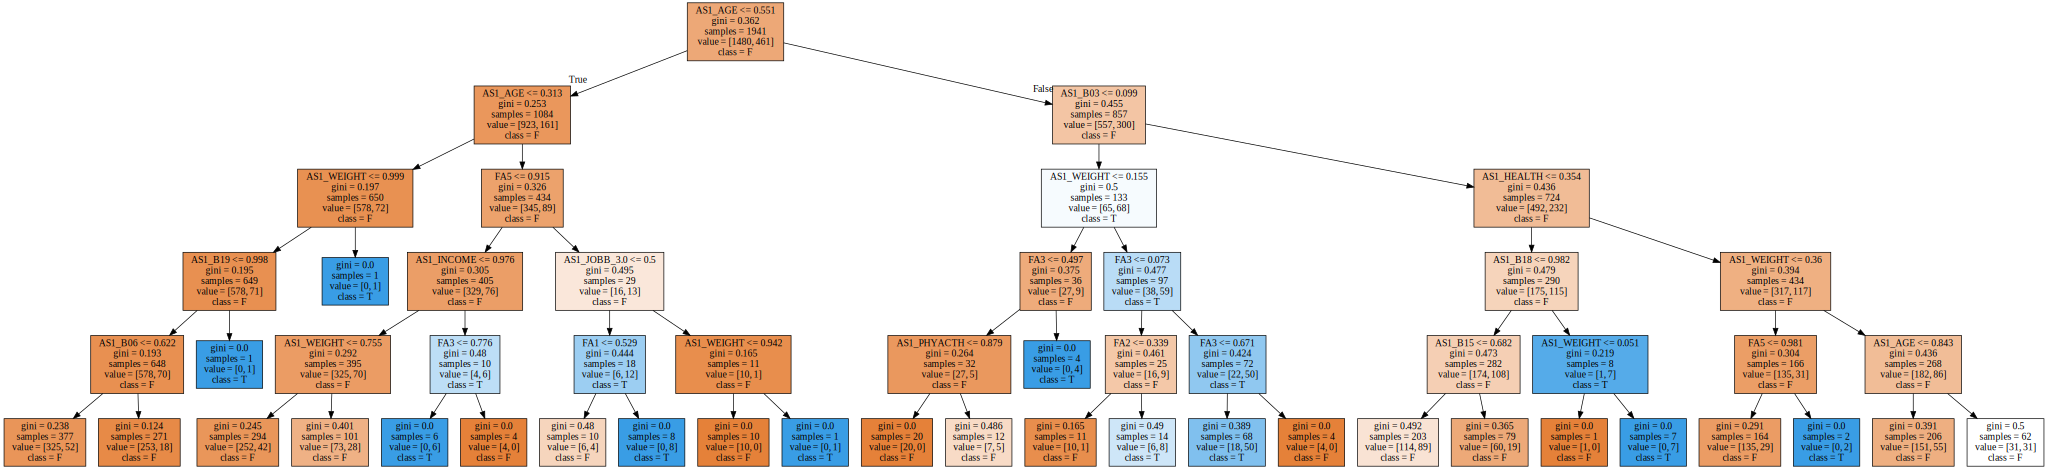

In [15]:
with open("tree.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph, filename='tree.png',format='png')

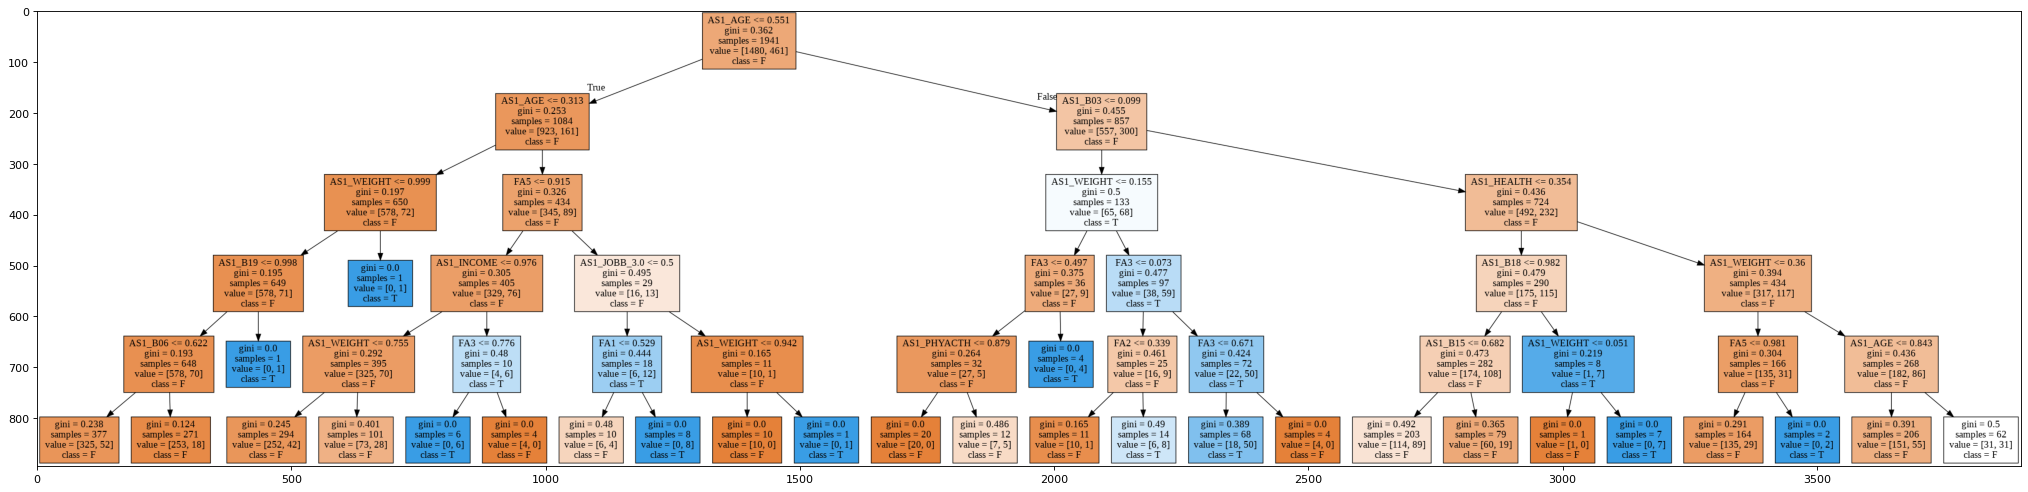

In [16]:
!dot -Tpng tree.dot -o tree.png

tree_img = plt.imread('./tree.png')

plt.figure(num=None, figsize=(32, 9), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(tree_img)

In [17]:
print("훈련 세트 정확도: {:.3f}".format(ht_tree.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(ht_tree.score(X_test, y_test)))

importances = ht_tree.feature_importances_

tree_importances = pd.DataFrame({'feature_importances' : importances}, index=X.columns )
tree_importances.sort_values(by=['feature_importances'], axis=0, inplace=True)

훈련 세트 정확도: 0.747
테스트 세트 정확도: 0.795


Text(0, 0.5, 'feature importance')

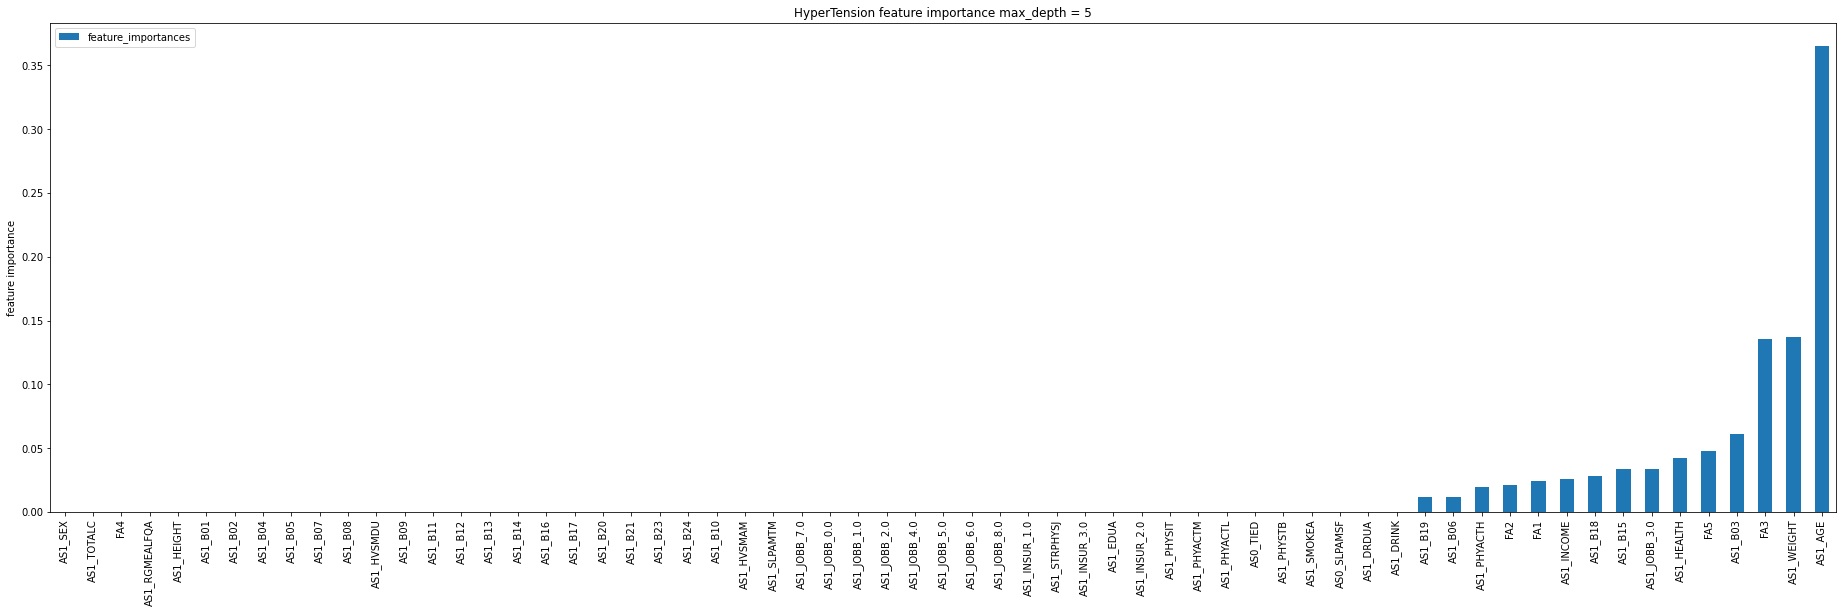

In [18]:
# 특성 중요도 그래프
fig, ax = plt.subplots(figsize=(32, 9))
tree_importances.plot.bar(ax=ax)
ax.set_title("HyperTension feature importance max_depth = 5")
ax.set_ylabel("feature importance")

### 특성 중요도가 낮은 것 제외하고 모델 제작해보기

- Decision tree로 변수의 특성 중요도 추출,

In [ ]:
tree_importances_0 = tree_importances[tree_importances.feature_importances > 0]
tree_importances_0

In [ ]:
importances_rank = tree_importances.index.to_numpy()

X_cut10 = X[importances_rank[10:]] # 변수 중요도 하위 10개 제거
X_cut20 = X[importances_rank[20:]] # 변수 중요도 하위 20개 제거
X_cut30 = X[importances_rank[30:]]
X_cut40 = X[importances_rank[40:]]
X_cut50 = X[importances_rank[50:]]

X_cut = X[tree_importances_0.index]

In [ ]:
X_cut_train, X_cut_test, y_train, y_test = train_test_split(X_cut, y, test_size=0.2)
print(X_cut_train.shape, X_cut_test.shape, y_train.shape, y_test.shape)

In [ ]:
input_shape = (X_cut_train.shape[1],)
cutted_hypermodel = RegressionHyperModel(input_shape)

tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = EPOCH,
                     hyperband_iterations = 100,
                     directory = '/content/drive/MyDrive/Colab Notebooks',
                     project_name = 'HyperTension_cutted_sh22h01')

tuner.search(X_cut_train, y_train,
             epochs = EPOCH,
            #  validation_data = (X_test, y_test),
             validation_split=0.2,
             callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete.
The optimal number of units in the densely-connected layer is
{best_hps.get('units')}
and the optimal learning rate for the optimizer is
{best_hps.get('learning_rate')}
drop-out is
{best_hps.get('dropout')}.
""")

### 하위 50개 제거 모델

```
Trial 365 Complete [00h 00m 03s]
val_accuracy: 0.769478440284729

Best val_accuracy So Far: 0.7746297717094421
Total elapsed time: 01h 02m 19s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
The optimal number of units in the densely-connected layer is
48
and the optimal learning rate for the optimizer is
0.001
drop-out is
0.05.
```

### 상위 18 모델

```
Trial 374 Complete [00h 00m 06s]
val_accuracy: 0.7720540761947632

Best val_accuracy So Far: 0.7759175896644592
Total elapsed time: 01h 08m 56s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
The optimal number of units in the densely-connected layer is
60
and the optimal learning rate for the optimizer is
0.001
drop-out is
0.05.
```